In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Making the Network

### Correlation Matrix

In [2]:

df = pd.read_csv(r"C:\Users\MadiL\Thesis CodeBase\Cross-Sectional\lsas_together.csv")

lsas_columns = [col for col in df.columns if "LSAS" in col]
cfs_columns = [col for col in df.columns if "CFS" in col]
bdi_columns = [col for col in df.columns if "BDI" in col]


# Subset the dataframe
### If we want to use demographics, don't subset
df_subset = df[lsas_columns + cfs_columns + bdi_columns].copy()

#df_subset[cfs_columns] = abs(df_subset[cfs_columns])

# Reverse score CFS questions 2, 3, 5, 10 in place
reverse_columns = ['CFS_2', 'CFS_3', 'CFS_5', 'CFS_10']

# Apply the reverse scoring transformation in place
df_subset[reverse_columns] = 7 - df_subset[reverse_columns]

# Reverse the direction of all CFS columns by multiplying by -1
df_subset[cfs_columns] = df_subset[cfs_columns] * -1


# Define a function to standardize values
# Ensures all columns have a mean of 0 and a standard deviation of 1
def standardize(df_column):
    return (df_column - df_column.mean()) / df_column.std()

# Standardize LSAS columns
df_subset[lsas_columns] = df_subset[lsas_columns].apply(standardize)

# Standardize CFS columns
df_subset[cfs_columns] = df_subset[cfs_columns].apply(standardize)

# Standardize BDI columns
df_subset[bdi_columns] = df_subset[bdi_columns].apply(standardize)

# Create a new DataFrame containing all the standardized individual items
df_standardized = df_subset[lsas_columns + cfs_columns + bdi_columns]

# Compute the correlation matrix for the standardized data
standardized_correlation_matrix = df_standardized.corr()

# Display the correlation matrix for review
## Make sure all correlations are positive!
print("Correlation Matrix:")
print(standardized_correlation_matrix)



Correlation Matrix:
                                   LSAS_1    LSAS_2    LSAS_3    LSAS_4  \
LSAS_1                           1.000000  0.540052  0.503552  0.493545   
LSAS_2                           0.540052  1.000000  0.492326  0.475663   
LSAS_3                           0.503552  0.492326  1.000000  0.658436   
LSAS_4                           0.493545  0.475663  0.658436  1.000000   
LSAS_5                           0.490704  0.562986  0.419728  0.426363   
LSAS_6                           0.346889  0.533581  0.238667  0.248859   
LSAS_7                           0.498186  0.599859  0.452592  0.471031   
LSAS_8                           0.494549  0.550702  0.433692  0.397988   
LSAS_9                           0.499450  0.530648  0.439289  0.415883   
LSAS_10                          0.571626  0.566543  0.370918  0.360379   
LSAS_11                          0.522521  0.645424  0.437495  0.427805   
LSAS_12                          0.499269  0.611358  0.432565  0.438106   
LSAS_

### Building a Network

In [3]:
correlation_matrix = standardized_correlation_matrix
# Set a correlation threshold to define a "strong" connection
threshold = 0.4

# Initialize an empty graph
G = nx.Graph()

# Add edges for pairs of questions that have a correlation above the threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if np.abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j],
                       weight=correlation_matrix.iloc[i, j])
            

# Number of nodes in the graph
print(f"Number of nodes: {G.number_of_nodes()}")

# Number of edges in the graph
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 56
Number of edges: 444


### Visualize the Network

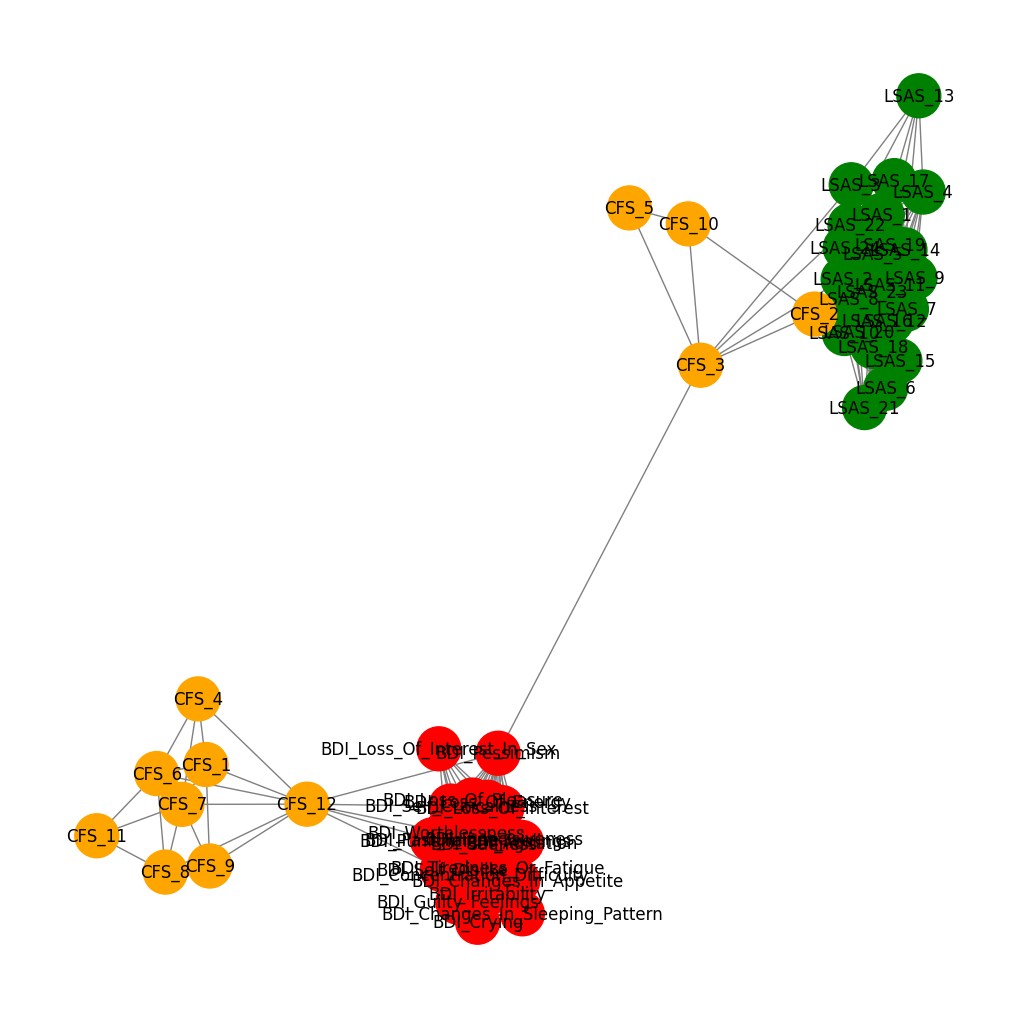

In [4]:
import networkx as nx
import matplotlib.pyplot as plt


# Define a function to color nodes based on their survey type
def get_node_color(node):
    if "LSAS" in node:
        return 'green'
    elif "CFS" in node:
        return 'orange'
    elif "BDI" in node:
        return 'red'
    else:
        return 'gray'  # Default color for unrecognized nodes

# Assign colors to nodes based on their labels
node_colors = [get_node_color(node) for node in G.nodes]

# Define node positions using spring layout
pos = nx.spring_layout(G)  # You can also try other layouts like nx.circular_layout(G)


# Create the plot
plt.figure(figsize=(10, 10))

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray')

# Show the plot
plt.show()

## Community Detection and Visualization

Number of communities: 3
Modularity score: 0.5206


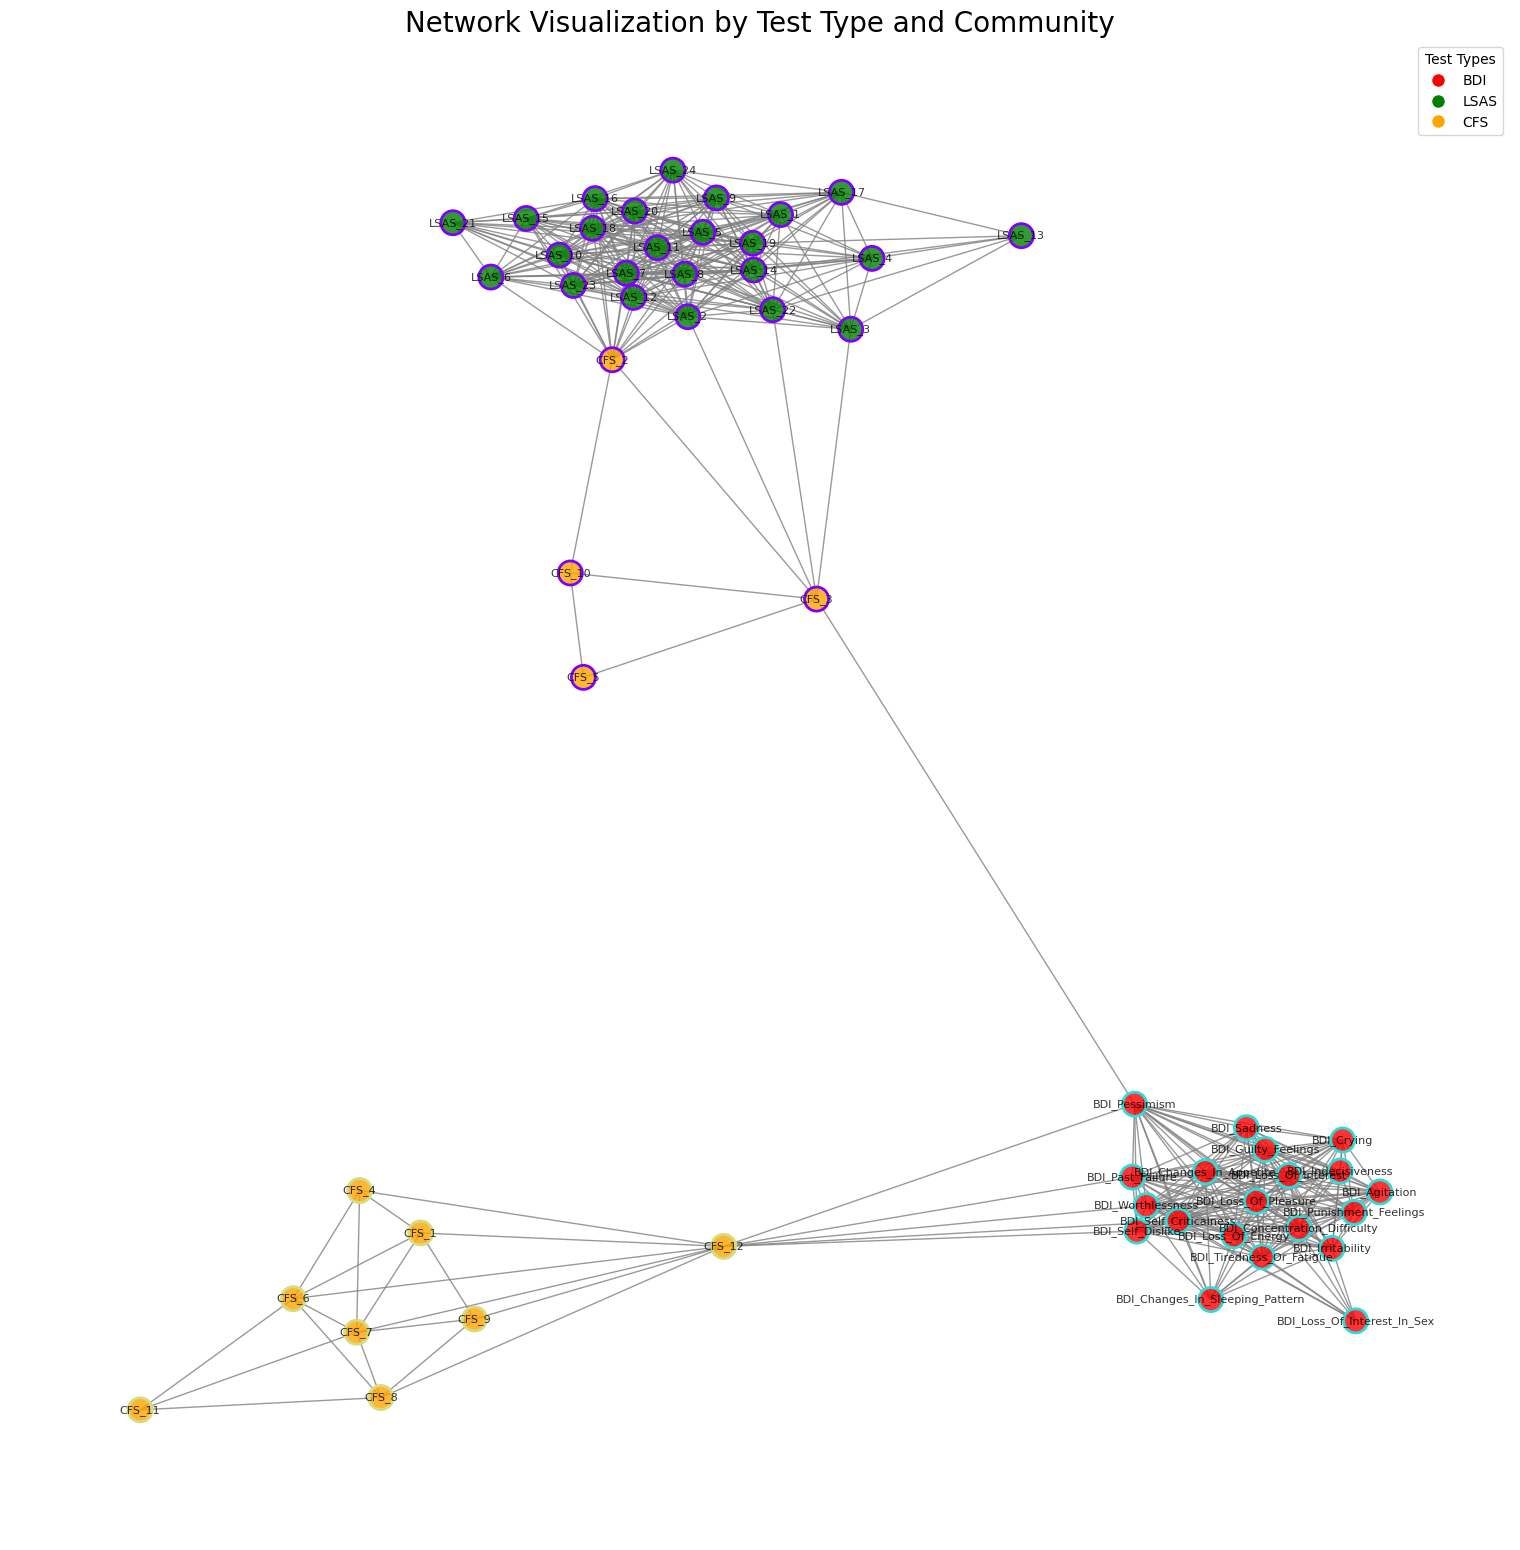

In [28]:
from networkx.algorithms import community
import matplotlib.pyplot as plt

# Greedy modularity optimization
communities = community.greedy_modularity_communities(G)
modularity = community.modularity(G, communities)

print(f"Number of communities: {len(communities)}")
print(f"Modularity score: {modularity:.4f}")

# Define base colors for each test type
test_color_map = {
    'BDI': 'red',
    'LSAS': 'green',
    'CFS': 'orange'
}

# Assign base colors to nodes based on their test type
node_colors = []
for node in G.nodes():
    if 'BDI' in node:
        node_colors.append(test_color_map['BDI'])
    elif 'LSAS' in node:
        node_colors.append(test_color_map['LSAS'])
    elif 'CFS' in node:
        node_colors.append(test_color_map['CFS'])

# Assign a unique outline color to each community
outline_color_map = {i: plt.cm.rainbow(i / len(communities)) for i in range(len(communities))}

# Prepare outline colors for nodes based on their community
outline_colors = []
for node in G.nodes():
    for i, community_nodes in enumerate(communities):
        if node in community_nodes:
            outline_colors.append(outline_color_map[i])
            break

# Fix the layout for consistent node positioning
pos = nx.spring_layout(G, seed=42)

# Plot the network with dual coloring
plt.figure(figsize=(15, 15))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_color='gray',
    node_size=300,
    font_size=8,
    alpha=0.8
)

# Draw node outlines for community differentiation
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=300,
    node_color='none',  # Transparent nodes
    edgecolors=outline_colors,  # Use community colors as outlines
    linewidths=2
)

# Create a legend for test types
handles_test = [
    plt.Line2D([0], [0], marker='o', color='w', label='BDI', markersize=10, markerfacecolor='red'),
    plt.Line2D([0], [0], marker='o', color='w', label='LSAS', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='CFS', markersize=10, markerfacecolor='orange')
]
plt.legend(handles=handles_test, loc='upper right', title="Test Types")

plt.title('Network Visualization by Test Type and Community', fontsize=20)
plt.show()


## Degree Centrality

Top 10 nodes by degree centrality:
Node: LSAS_2, Centrality: 0.43636363636363634
Node: LSAS_11, Centrality: 0.41818181818181815
Node: LSAS_14, Centrality: 0.41818181818181815
Node: LSAS_19, Centrality: 0.41818181818181815
Node: LSAS_5, Centrality: 0.39999999999999997
Node: LSAS_7, Centrality: 0.39999999999999997
Node: LSAS_8, Centrality: 0.39999999999999997
Node: LSAS_12, Centrality: 0.39999999999999997
Node: LSAS_9, Centrality: 0.3818181818181818
Node: LSAS_16, Centrality: 0.3818181818181818


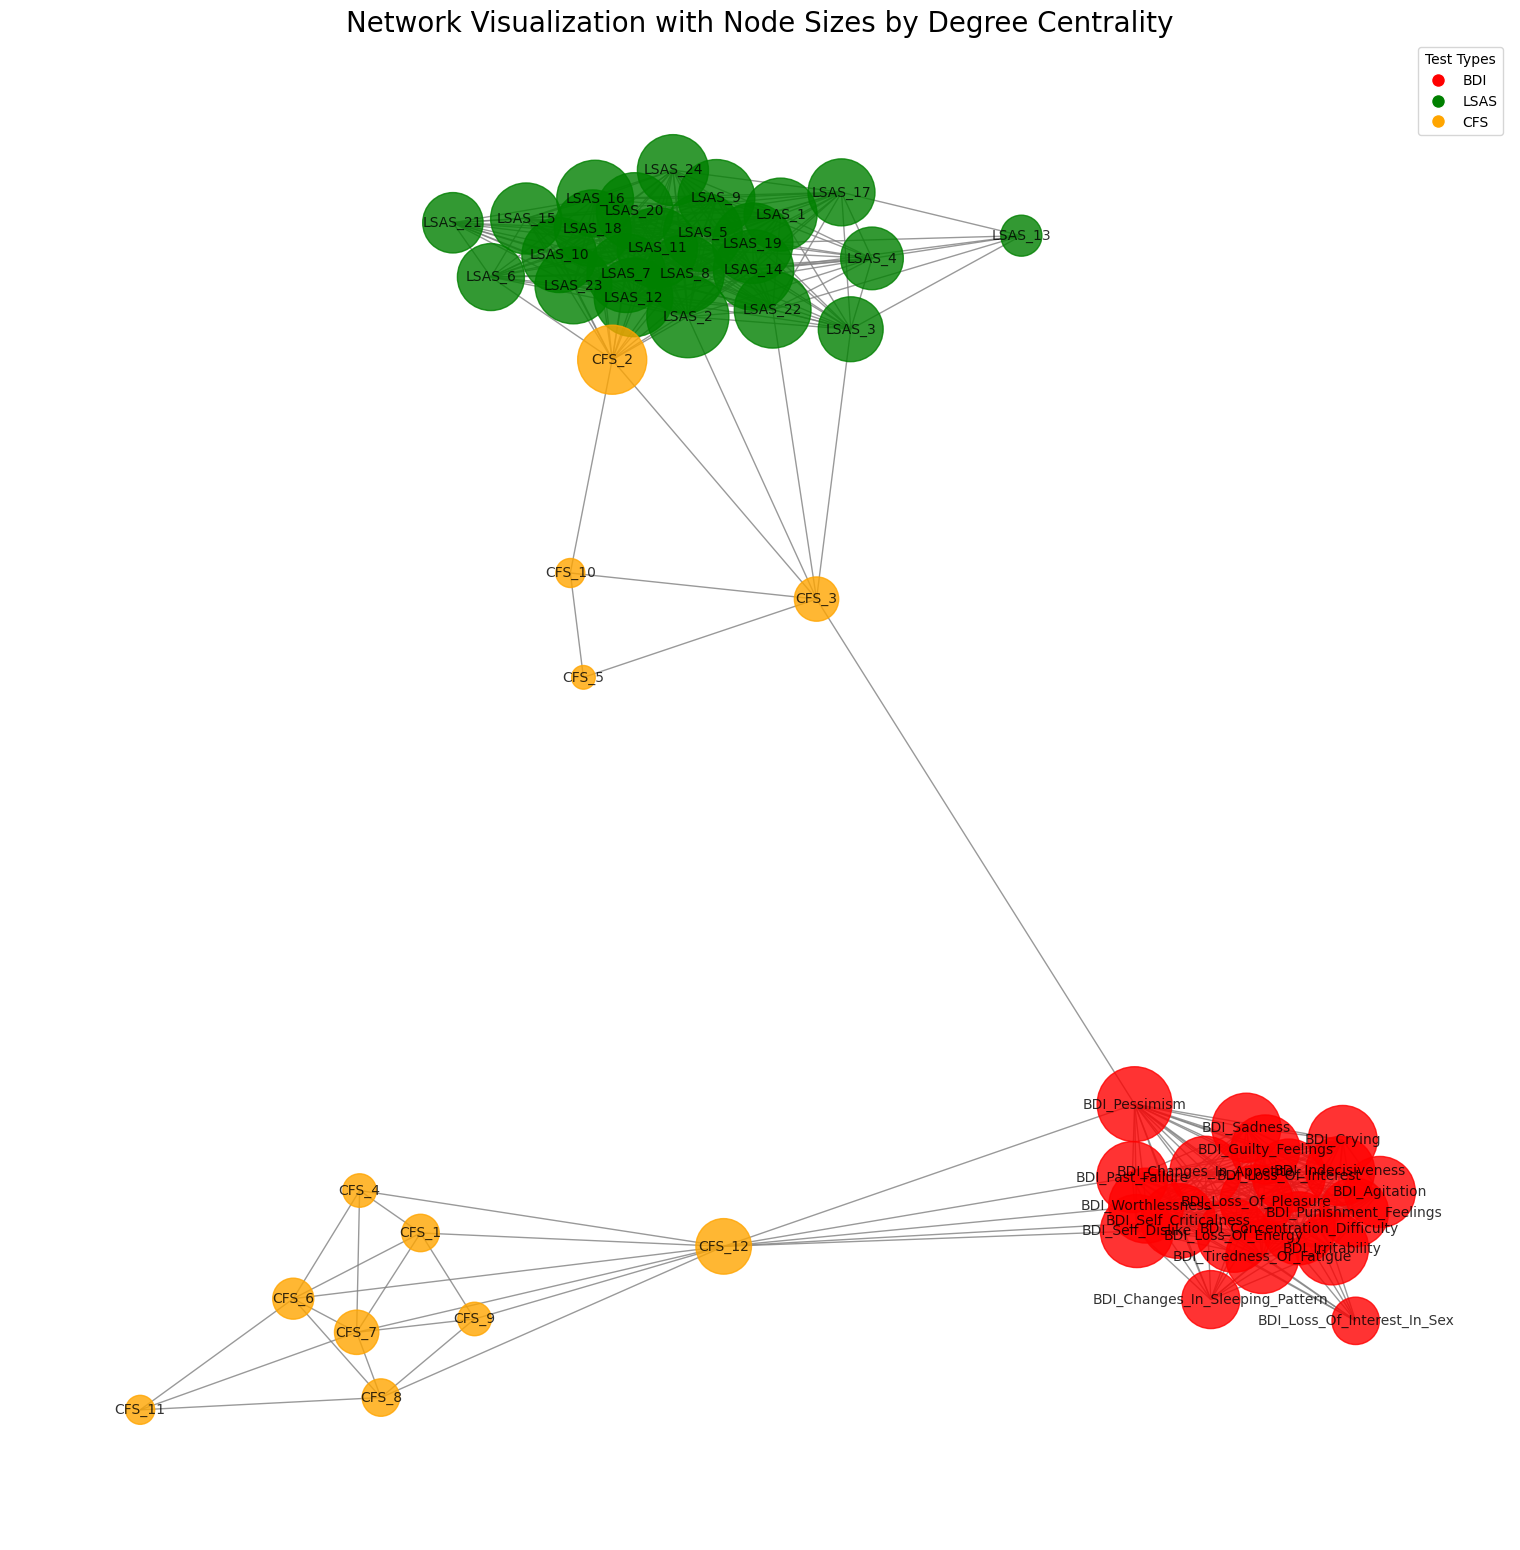

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

# Degree centrality
centrality = nx.degree_centrality(G)

# Top 10 central nodes
top_central_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by degree centrality:")
for node, centrality_score in top_central_nodes:
    print(f"Node: {node}, Centrality: {centrality_score}")

# Define color mapping by test type
color_map = []
for node in G.nodes():
    if 'BDI' in node:
        color_map.append('red')
    elif 'LSAS' in node:
        color_map.append('green')
    elif 'CFS' in node:
        color_map.append('orange')

# Visualize centrality
node_sizes = [8000 * centrality[node] for node in G.nodes()]  # Adjusted scaling for clarity
plt.figure(figsize=(15, 15))  # Increase figure size
pos = nx.spring_layout(G, seed=42)  # Consistent layout for readability

# Draw the graph with color coding
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=color_map,  # Use color map based on test type
    font_size=10,  # Larger font size for labels
    font_color='black',
    edge_color='gray',
    alpha=0.8
)

# Add a legend for test types
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='BDI', markersize=10, markerfacecolor='red'),
    plt.Line2D([0], [0], marker='o', color='w', label='LSAS', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='CFS', markersize=10, markerfacecolor='orange')
]
plt.legend(handles=handles, loc='upper right', title="Test Types")

plt.title('Network Visualization with Node Sizes by Degree Centrality', fontsize=20)
plt.show()


## Bridge Centrality

Top 10 bridge nodes:
Node: CFS_2, Bridge Centrality: 15
Node: CFS_12, Bridge Centrality: 5
Node: CFS_3, Bridge Centrality: 4
Node: LSAS_2, Bridge Centrality: 2
Node: BDI_Pessimism, Bridge Centrality: 2
Node: LSAS_3, Bridge Centrality: 1
Node: LSAS_5, Bridge Centrality: 1
Node: LSAS_7, Bridge Centrality: 1
Node: LSAS_8, Bridge Centrality: 1
Node: LSAS_10, Bridge Centrality: 1


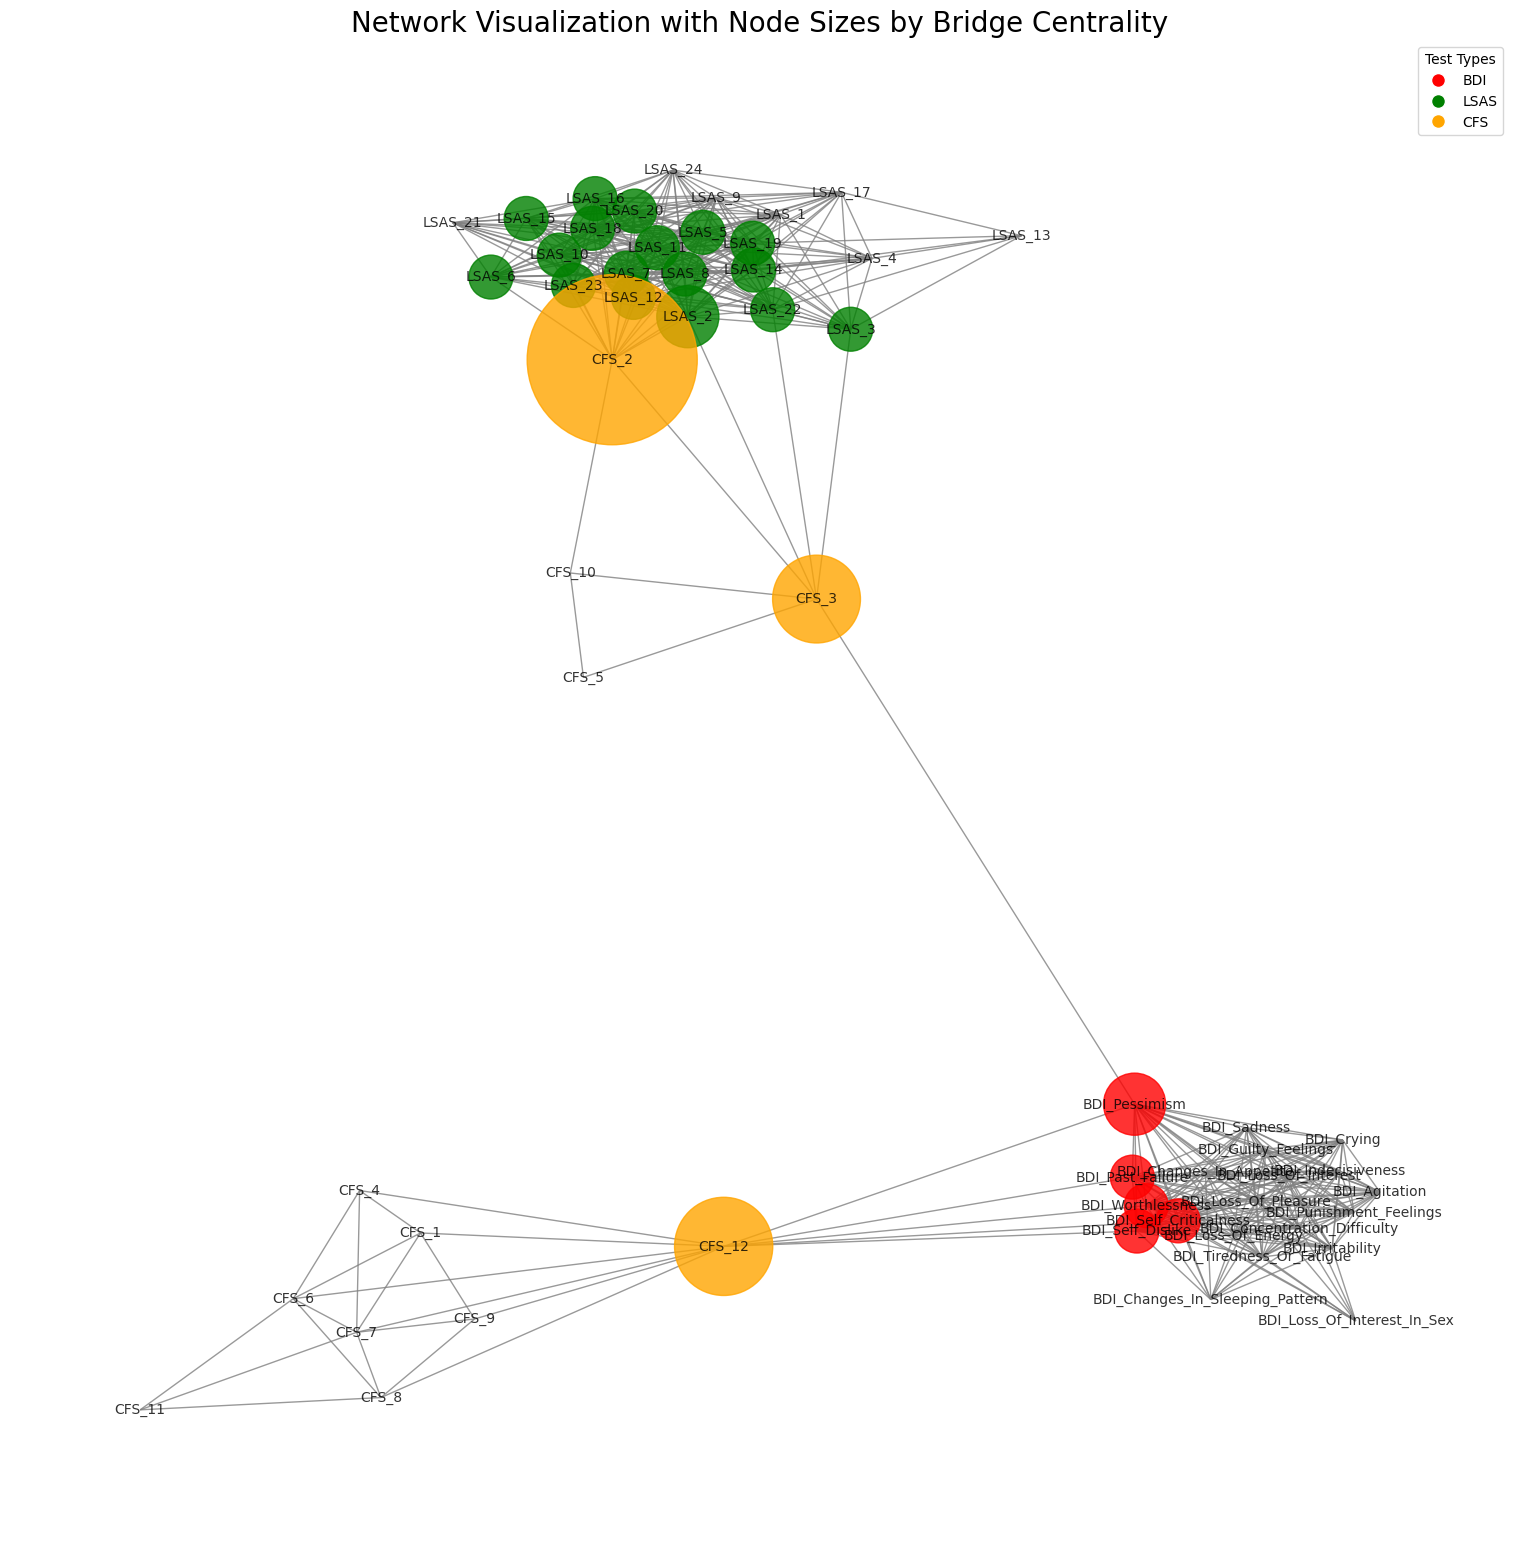

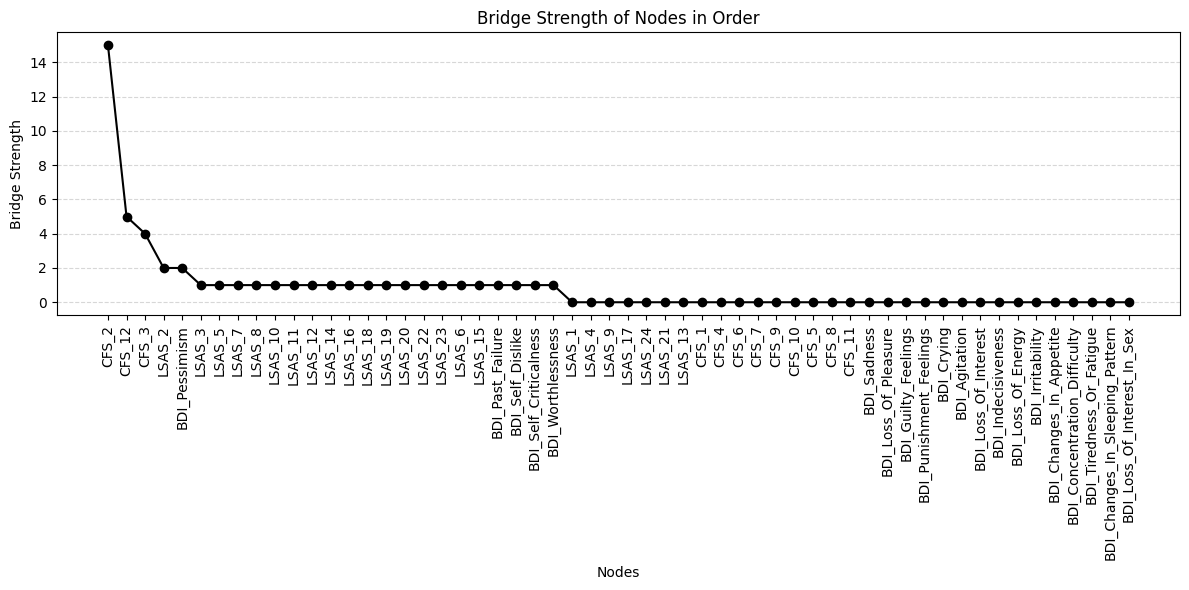

In [35]:

def calculate_bridge_centrality(G, scale_groups):
    """
    Calculate bridge centrality for nodes connecting different scale groups.

    Parameters:
    - G: NetworkX graph
    - scale_groups: A dictionary where keys are scale names and values are lists of nodes belonging to each scale

    Returns:
    - bridge_centrality: A dictionary with nodes as keys and bridge centrality scores as values
    """
    bridge_centrality = {node: 0 for node in G.nodes()}
    
    # Iterate over all edges
    for node1, node2 in G.edges():
        group1 = next((scale for scale, nodes in scale_groups.items() if node1 in nodes), None)
        group2 = next((scale for scale, nodes in scale_groups.items() if node2 in nodes), None)
        
        # If the nodes belong to different groups, increment bridge centrality
        if group1 != group2:
            bridge_centrality[node1] += 1
            bridge_centrality[node2] += 1
    
    return bridge_centrality

# Example usage of bridge centrality calculation
# Define scale groups (modify according to your dataset)
scale_groups = {
    'LSAS': [col for col in df_standardized.columns if 'LSAS' in col],
    'BDI': [col for col in df_standardized.columns if 'BDI' in col],
    'CFS': [col for col in df_standardized.columns if 'CFS' in col]
}
bridge_centrality_scores = calculate_bridge_centrality(G, scale_groups)

# Display top bridge nodes
top_bridge_nodes = sorted(bridge_centrality_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 bridge nodes:")
for node, score in top_bridge_nodes:
    print(f"Node: {node}, Bridge Centrality: {score}")

# Visualize the graph with bridge centrality and color coding by test type
node_sizes = [1000 * bridge_centrality_scores[node] for node in G.nodes()]

# Define color mapping by test type
color_map = []
for node in G.nodes():
    if 'BDI' in node:
        color_map.append('red')
    elif 'LSAS' in node:
        color_map.append('green')
    elif 'CFS' in node:
        color_map.append('orange')

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, seed=42)  # Consistent layout for readability

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=color_map,  # Use color map based on test type
    font_size=10,
    font_color='black',
    edge_color='gray',
    alpha=0.8
)

# Add a legend for test types
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='BDI', markersize=10, markerfacecolor='red'),
    plt.Line2D([0], [0], marker='o', color='w', label='LSAS', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='CFS', markersize=10, markerfacecolor='orange')
]
plt.legend(handles=handles, loc='upper right', title="Test Types")

plt.title('Network Visualization with Node Sizes by Bridge Centrality', fontsize=20)
plt.show()



import matplotlib.pyplot as plt

# Sort bridge centrality scores in descending order
sorted_bridge_nodes = sorted(bridge_centrality_scores.items(), key=lambda x: x[1], reverse=True)

# Extract node names and their bridge strengths
nodes, bridge_strengths = zip(*sorted_bridge_nodes)

# Plot bridge strength values
plt.figure(figsize=(12, 6))
plt.plot(nodes, bridge_strengths, marker='o', linestyle='-', color='black')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Nodes')
plt.ylabel('Bridge Strength')
plt.title('Bridge Strength of Nodes in Order')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



## Edge Weight Analysis

In [20]:
# Analyze strongest edges across different tests
cross_scale_edges = []
for u, v, data in G.edges(data=True):
    group1 = next((scale for scale, nodes in scale_groups.items() if u in nodes), None)
    group2 = next((scale for scale, nodes in scale_groups.items() if v in nodes), None)
    if group1 != group2:
        cross_scale_edges.append((u, v, data['weight']))

# Sort cross-scale edges by absolute weight
sorted_cross_scale_edges = sorted(cross_scale_edges, key=lambda x: abs(x[2]), reverse=True)

print("Top 10 Strongest Edges - Across Tests:")
for u, v, weight in sorted_cross_scale_edges[:10]:
    print(f"Edge: ({u}, {v}), Weight: {weight:.4f}")
print("") # Empty line!!!
# Get edges sorted by absolute weight for within-scale analysis
sorted_edges = sorted(G.edges(data=True), key=lambda x: abs(x[2]['weight']), reverse=True)

print("Top 10 Strongest Edges - Absolute:")
for u, v, data in sorted_edges[:10]:
    print(f"Edge: ({u}, {v}), Weight: {data['weight']:.4f}")
print("") # Empty line!!!


# Get edges sorted by absolute weight
sorted_edges = sorted(G.edges(data=True), key=lambda x: abs(x[2]['weight']), reverse=True)


Top 10 Strongest Edges - Across Tests:
Edge: (LSAS_11, CFS_2), Weight: 0.5533
Edge: (LSAS_12, CFS_2), Weight: 0.5398
Edge: (LSAS_16, CFS_2), Weight: 0.5250
Edge: (LSAS_2, CFS_2), Weight: 0.5102
Edge: (LSAS_15, CFS_2), Weight: 0.5066
Edge: (LSAS_7, CFS_2), Weight: 0.4994
Edge: (LSAS_20, CFS_2), Weight: 0.4906
Edge: (LSAS_10, CFS_2), Weight: 0.4798
Edge: (LSAS_18, CFS_2), Weight: 0.4696
Edge: (LSAS_19, CFS_2), Weight: 0.4594

Top 10 Strongest Edges - Absolute:
Edge: (LSAS_11, LSAS_12), Weight: 0.8243
Edge: (BDI_Past_Failure, BDI_Worthlessness), Weight: 0.7642
Edge: (LSAS_10, LSAS_11), Weight: 0.7349
Edge: (BDI_Self_Dislike, BDI_Worthlessness), Weight: 0.7333
Edge: (BDI_Loss_Of_Energy, BDI_Tiredness_Or_Fatigue), Weight: 0.7276
Edge: (BDI_Self_Dislike, BDI_Self_Criticalness), Weight: 0.7228
Edge: (LSAS_8, LSAS_9), Weight: 0.7189
Edge: (BDI_Loss_Of_Pleasure, BDI_Loss_Of_Interest), Weight: 0.7164
Edge: (BDI_Past_Failure, BDI_Self_Dislike), Weight: 0.7138
Edge: (LSAS_16, LSAS_20), Weight: 0.7

## Betweenness Centrality

Top 10 Nodes by Betweenness Centrality:
Node: CFS_3, Betweenness Centrality: 0.5262
Node: BDI_Pessimism, Betweenness Centrality: 0.5248
Node: CFS_12, Betweenness Centrality: 0.2270
Node: LSAS_2, Betweenness Centrality: 0.1490
Node: LSAS_22, Betweenness Centrality: 0.1190
Node: CFS_2, Betweenness Centrality: 0.1042
Node: LSAS_3, Betweenness Centrality: 0.0736
Node: BDI_Self_Criticalness, Betweenness Centrality: 0.0217
Node: BDI_Worthlessness, Betweenness Centrality: 0.0217
Node: BDI_Self_Dislike, Betweenness Centrality: 0.0157


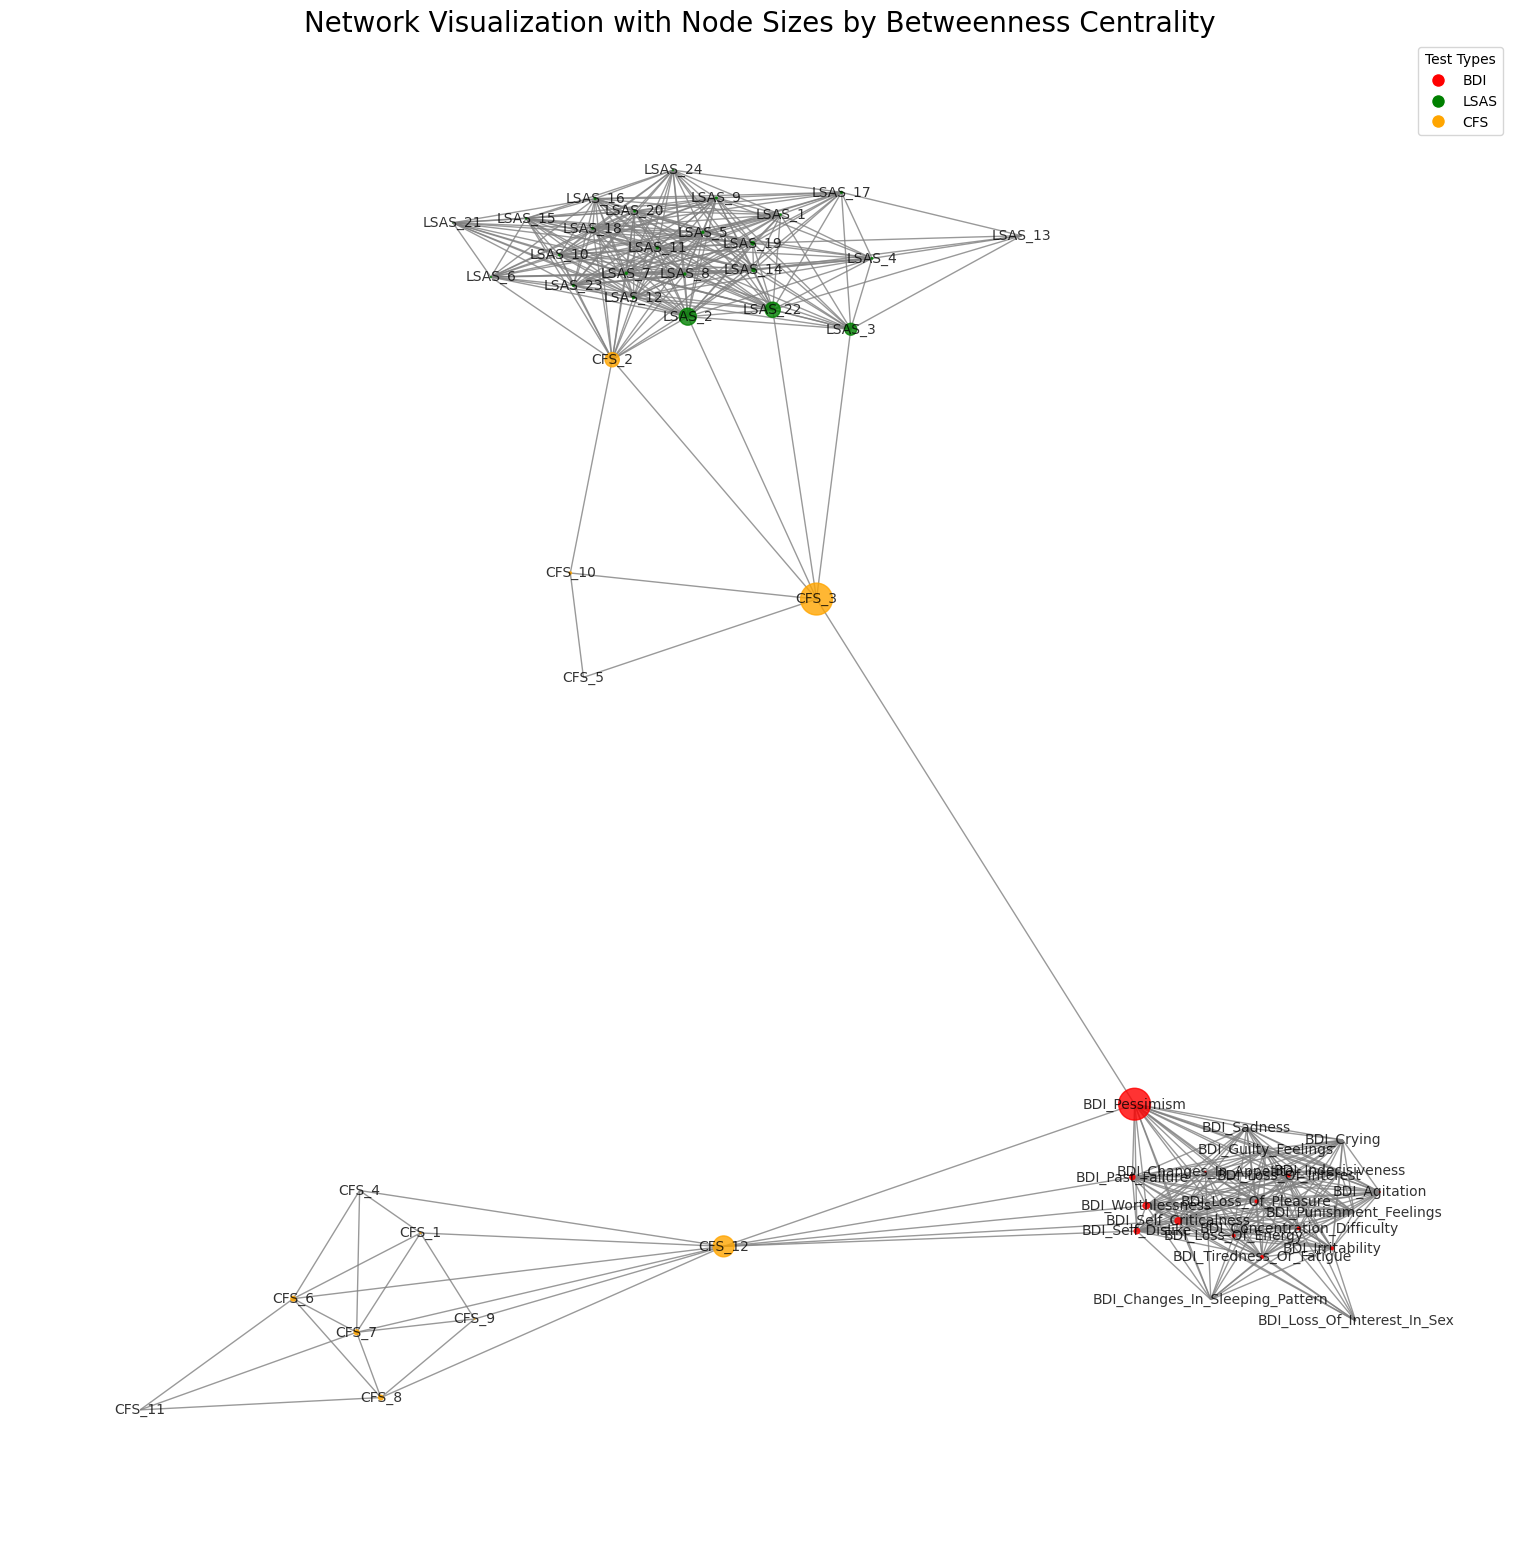

In [36]:
# Betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Display top 10 nodes by betweenness centrality
top_betweenness_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Nodes by Betweenness Centrality:")
for node, score in top_betweenness_nodes:
    print(f"Node: {node}, Betweenness Centrality: {score:.4f}")

# Define color mapping by test type
color_map = []
for node in G.nodes():
    if 'BDI' in node:
        color_map.append('red')
    elif 'LSAS' in node:
        color_map.append('green')
    elif 'CFS' in node:
        color_map.append('orange')

# Visualize betweenness centrality
node_sizes = [1000 * betweenness[node] for node in G.nodes()]
plt.figure(figsize=(15, 15))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=color_map,  # Use color map based on test type
    font_size=10,
    font_color='black',
    edge_color='gray',
    alpha=0.8
)

# Add a legend for test types
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='BDI', markersize=10, markerfacecolor='red'),
    plt.Line2D([0], [0], marker='o', color='w', label='LSAS', markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label='CFS', markersize=10, markerfacecolor='orange')
]
plt.legend(handles=handles, loc='upper right', title="Test Types")

plt.title('Network Visualization with Node Sizes by Betweenness Centrality', fontsize=20)
plt.show()


## Community Detection

In [37]:
# Community detection
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print("Detected communities:", [list(c) for c in communities])

Detected communities: [['LSAS_17', 'CFS_2', 'LSAS_8', 'CFS_5', 'LSAS_5', 'LSAS_7', 'LSAS_14', 'LSAS_11', 'LSAS_18', 'LSAS_19', 'LSAS_12', 'LSAS_21', 'LSAS_20', 'LSAS_2', 'LSAS_15', 'LSAS_4', 'LSAS_3', 'LSAS_23', 'LSAS_24', 'LSAS_16', 'CFS_3', 'LSAS_13', 'LSAS_6', 'CFS_10', 'LSAS_22', 'LSAS_9', 'LSAS_10', 'LSAS_1'], ['BDI_Changes_In_Appetite', 'BDI_Sadness', 'BDI_Changes_In_Sleeping_Pattern', 'BDI_Worthlessness', 'BDI_Loss_Of_Interest_In_Sex', 'BDI_Pessimism', 'BDI_Loss_Of_Pleasure', 'BDI_Loss_Of_Interest', 'BDI_Concentration_Difficulty', 'BDI_Indecisiveness', 'BDI_Self_Criticalness', 'BDI_Loss_Of_Energy', 'BDI_Crying', 'BDI_Agitation', 'BDI_Punishment_Feelings', 'BDI_Self_Dislike', 'BDI_Irritability', 'BDI_Guilty_Feelings', 'BDI_Past_Failure', 'BDI_Tiredness_Or_Fatigue'], ['CFS_12', 'CFS_1', 'CFS_4', 'CFS_8', 'CFS_6', 'CFS_9', 'CFS_11', 'CFS_7']]


## Predictability Analysis


Predictability Scores:
Node: LSAS_11, Predictability: 0.7637
Node: LSAS_12, Predictability: 0.7206
Node: BDI_Worthlessness, Predictability: 0.7159
Node: BDI_Past_Failure, Predictability: 0.6929
Node: BDI_Self_Dislike, Predictability: 0.6709
Node: LSAS_16, Predictability: 0.6555
Node: LSAS_20, Predictability: 0.6493
Node: BDI_Self_Criticalness, Predictability: 0.6464
Node: BDI_Tiredness_Or_Fatigue, Predictability: 0.6302
Node: LSAS_8, Predictability: 0.6295
Node: LSAS_10, Predictability: 0.6278
Node: BDI_Loss_Of_Pleasure, Predictability: 0.6198
Node: BDI_Loss_Of_Interest, Predictability: 0.6175
Node: LSAS_7, Predictability: 0.6156
Node: BDI_Pessimism, Predictability: 0.6148
Node: BDI_Loss_Of_Energy, Predictability: 0.6121
Node: LSAS_2, Predictability: 0.5976
Node: LSAS_15, Predictability: 0.5942
Node: LSAS_9, Predictability: 0.5863
Node: LSAS_23, Predictability: 0.5775
Node: LSAS_6, Predictability: 0.5740
Node: BDI_Concentration_Difficulty, Predictability: 0.5520
Node: LSAS_3, Predicta

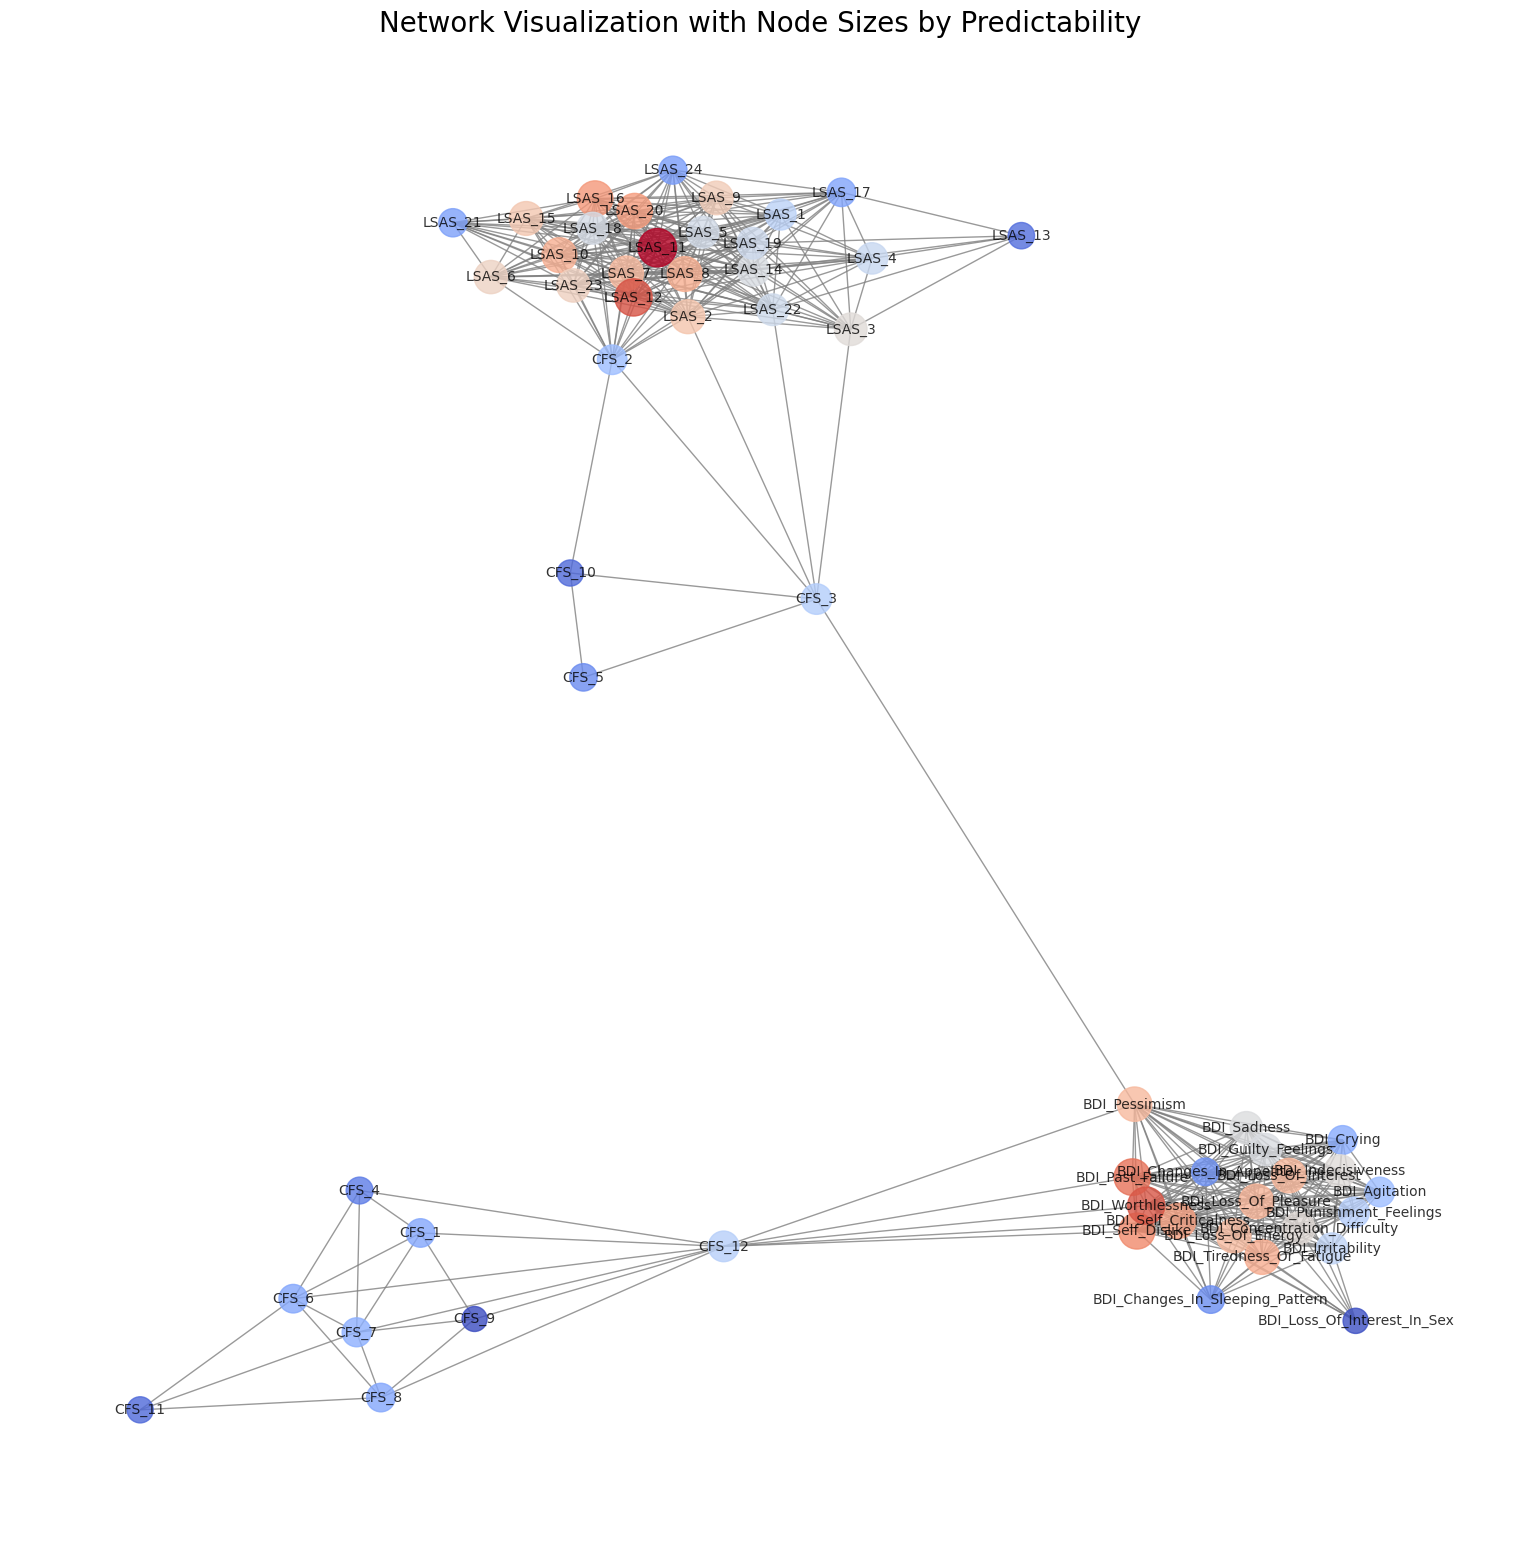

In [38]:
predictability_scores = {}

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    if not neighbors:
        predictability_scores[node] = 0
        continue
    
    # Prepare data for regression
    X = df_standardized[neighbors]
    y = df_standardized[node]
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    
    # Calculate R^2 as predictability
    predictability = model.score(X, y)
    predictability_scores[node] = predictability

# Display predictability scores
print("\nPredictability Scores:")
for node, score in sorted(predictability_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"Node: {node}, Predictability: {score:.4f}")

# Visualize predictability scores
node_sizes = [1000 * predictability_scores[node] for node in G.nodes()]
plt.figure(figsize=(15, 15))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    cmap=plt.cm.coolwarm,
    node_color=list(predictability_scores.values()),
    font_size=10,
    font_color='black',
    edge_color='gray',
    alpha=0.8
)
plt.title('Network Visualization with Node Sizes by Predictability', fontsize=20)
plt.show()


## Descriptive Statistics From Antiquity

### Most/Least Connected Nodes

Shows nodes (questions) with the most and least degrees (number of connected edges)

In [39]:
import networkx as nx

# Assuming G is your graph from the previous steps

# Calculate the degree of each node
degree_dict = dict(G.degree())

# Find the most connected question(s)
most_connected = max(degree_dict, key=degree_dict.get)
most_connected_degree = degree_dict[most_connected]

# Find the least connected question(s)
least_connected = min(degree_dict, key=degree_dict.get)
least_connected_degree = degree_dict[least_connected]

# Print the results
print(f"Most connected question: {most_connected}: degree {most_connected_degree}")
print(f"Least connected question: {least_connected}: degree {least_connected_degree}")

# Sort nodes by their degree in descending order
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

# Print the results
print("Questions and their degrees (from highest to lowest):")
for question, degree in sorted_degree:
    print(f"{question}: {degree}")

Most connected question: LSAS_2: degree 24
Least connected question: CFS_5: degree 2
Questions and their degrees (from highest to lowest):
LSAS_2: 24
LSAS_11: 23
LSAS_14: 23
LSAS_19: 23
LSAS_5: 22
LSAS_7: 22
LSAS_8: 22
LSAS_12: 22
LSAS_9: 21
LSAS_16: 21
LSAS_18: 21
LSAS_20: 21
LSAS_22: 21
LSAS_23: 21
LSAS_10: 20
BDI_Pessimism: 20
BDI_Self_Criticalness: 20
BDI_Worthlessness: 20
LSAS_1: 19
BDI_Self_Dislike: 19
BDI_Loss_Of_Pleasure: 19
BDI_Loss_Of_Interest: 19
BDI_Loss_Of_Energy: 19
BDI_Irritability: 19
BDI_Concentration_Difficulty: 19
BDI_Tiredness_Or_Fatigue: 19
LSAS_24: 18
LSAS_15: 18
BDI_Past_Failure: 18
BDI_Agitation: 18
BDI_Changes_In_Appetite: 18
CFS_2: 17
BDI_Sadness: 17
BDI_Guilty_Feelings: 17
BDI_Punishment_Feelings: 17
BDI_Crying: 17
BDI_Indecisiveness: 17
LSAS_17: 16
LSAS_6: 16
LSAS_3: 15
LSAS_4: 14
LSAS_21: 13
BDI_Changes_In_Sleeping_Pattern: 12
CFS_12: 11
BDI_Loss_Of_Interest_In_Sex: 8
CFS_3: 7
CFS_7: 7
LSAS_13: 6
CFS_6: 6
CFS_1: 5
CFS_8: 5
CFS_4: 4
CFS_9: 4
CFS_10: 3
CFS_11

### Correlation Pairs (within-test allowed)

In [40]:
import pandas as pd
import numpy as np

# Assuming correlation_matrix is your DataFrame with correlations

# Set the diagonal elements to NaN to avoid self-pairing
np.fill_diagonal(correlation_matrix.values, np.nan)

# Find the maximum correlation value in the matrix
max_corr = correlation_matrix.max().max()

# Find the minimum correlation value in the matrix
min_corr = correlation_matrix.min().min()

# Find the pairs with the maximum correlation
max_corr_pairs = np.where(correlation_matrix == max_corr)
max_corr_questions = list(zip(correlation_matrix.columns[max_corr_pairs[0]], correlation_matrix.columns[max_corr_pairs[1]]))

# Find the pairs with the minimum correlation
min_corr_pairs = np.where(correlation_matrix == min_corr)
min_corr_questions = list(zip(correlation_matrix.columns[min_corr_pairs[0]], correlation_matrix.columns[min_corr_pairs[1]]))

# Print the results
print(f"Maximum correlation value: {max_corr}")
print("Pairs with the maximum correlation:")
for pair in max_corr_questions:
    print(f"{pair[0]} and {pair[1]}")

print(f"\nMinimum correlation value: {min_corr}")
print("Pairs with the minimum correlation:")
for pair in min_corr_questions:
    print(f"{pair[0]} and {pair[1]}")



Maximum correlation value: 0.8243014329145768
Pairs with the maximum correlation:
LSAS_11 and LSAS_12
LSAS_12 and LSAS_11

Minimum correlation value: 0.0306330444518164
Pairs with the minimum correlation:
LSAS_6 and CFS_11
CFS_11 and LSAS_6


In [41]:
import pandas as pd
import numpy as np

# Assuming correlation_matrix is your DataFrame with correlations

# Set the diagonal elements to NaN to avoid self-pairing
np.fill_diagonal(correlation_matrix.values, np.nan)

# Function to determine if two columns belong to different tests
def different_tests(col1, col2):
    if (col1 in lsas_columns and col2 in lsas_columns) or \
       (col1 in cfs_columns and col2 in cfs_columns) or \
       (col1 in bdi_columns and col2 in bdi_columns):
        return False
    return True

# Function to get top N unique pairs (max or min correlations)
def get_top_n_pairs(correlation_matrix, n, max_or_min="max"):
    # Flatten the matrix to get correlations and pairs
    corr_unstacked = correlation_matrix.unstack()
    
    # Sort by correlation value
    if max_or_min == "max":
        sorted_corr = corr_unstacked.sort_values(ascending=False)
    else:
        sorted_corr = corr_unstacked.sort_values(ascending=True)
    
    # Filter out reverse pairs and pairs from the same test
    unique_pairs = []
    seen = set()
    for (col1, col2), corr_value in sorted_corr.items():
        if (col1, col2) not in seen and (col2, col1) not in seen and different_tests(col1, col2):
            unique_pairs.append((col1, col2, corr_value))
            seen.add((col1, col2))
            seen.add((col2, col1))  # Mark reverse pair as seen
        if len(unique_pairs) == n:
            break
    return unique_pairs

# Get 5 unique pairs with the highest correlations
highest_corr_pairs = get_top_n_pairs(correlation_matrix, 5, max_or_min="max")

# Get 5 unique pairs with the lowest correlations
lowest_corr_pairs = get_top_n_pairs(correlation_matrix, 5, max_or_min="min")

# Print the results
print("Top 5 pairs with the highest correlation (from different tests):")
for pair in highest_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation {pair[2]:.4f}")

print("\nTop 5 pairs with the lowest correlation (from different tests):")
for pair in lowest_corr_pairs:
    print(f"{pair[0]} and {pair[1]} with correlation {pair[2]:.4f}")


Top 5 pairs with the highest correlation (from different tests):
CFS_2 and LSAS_11 with correlation 0.5533
CFS_2 and LSAS_12 with correlation 0.5398
LSAS_16 and CFS_2 with correlation 0.5250
LSAS_2 and CFS_2 with correlation 0.5102
CFS_2 and LSAS_15 with correlation 0.5066

Top 5 pairs with the lowest correlation (from different tests):
LSAS_6 and CFS_11 with correlation 0.0306
CFS_11 and LSAS_21 with correlation 0.0315
LSAS_13 and CFS_4 with correlation 0.0428
CFS_11 and LSAS_18 with correlation 0.0644
LSAS_3 and CFS_4 with correlation 0.0652
